In [40]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.mask
import math
import datetime as dt
import json
import os
import re

from rasterio.enums import Resampling

In [113]:
folder = "LE07_L1TP_149035_20010101_20200917_02_T1"
#f_r = re.compile("LE07_L1TP_149035_\d{8}_20200917_02_T1")
#if f_r.match(folder) is not None:
#    print("matches")
folder.split('_')[3].strip()
date = dt.datetime.strptime(folder.split('_')[3].strip(),"%Y%m%d").date()
print(date)
if os.path.isdir(folder):
    pfolder = folder
elif os.path.isdir(os.path.join("data", folder)):
    pfolder = os.path.join("data", folder)
else:
    raise ValueError(
        "Please declare a valid date or folder name"
    )
print(pfolder)

B1 = os.path.join(pfolder, f"{folder}_B1.TIF")
if os.path.exists(B1):
    print(B1)

MTLJ = os.path.join(pfolder, f"{folder}_MTL.JSON")
if os.path.exists(MTLJ):
    print(MTLJ)
constants = {}
with open(MTLJ, 'r') as j:
    mtl = json.loads(j.read())
constants['Gain'] = float(mtl["LANDSAT_METADATA_FILE"]["LEVEL1_RADIOMETRIC_RESCALING"]["RADIANCE_MULT_BAND_6_VCID_2"])
constants['Offset'] = float(mtl["LANDSAT_METADATA_FILE"]["LEVEL1_RADIOMETRIC_RESCALING"]["RADIANCE_ADD_BAND_6_VCID_2"])
constants['K1'] = float(mtl["LANDSAT_METADATA_FILE"]["LEVEL1_THERMAL_CONSTANTS"]["K1_CONSTANT_BAND_6_VCID_2"])
constants['K2'] = float(mtl["LANDSAT_METADATA_FILE"]["LEVEL1_THERMAL_CONSTANTS"]["K2_CONSTANT_BAND_6_VCID_2"])
print(constants)

2001-01-01
data/LE07_L1TP_149035_20010101_20200917_02_T1
data/LE07_L1TP_149035_20010101_20200917_02_T1/LE07_L1TP_149035_20010101_20200917_02_T1_B1.TIF
data/LE07_L1TP_149035_20010101_20200917_02_T1/LE07_L1TP_149035_20010101_20200917_02_T1_MTL.JSON
{'Gain': 0.037205, 'Offset': 3.1628, 'K1': 666.09, 'K2': 1282.71}


In [123]:
with open(MTLJ, 'r') as j:
    mtl = json.loads(j.read())
    _spacecraft_id = mtl["LANDSAT_METADATA_FILE"]["IMAGE_ATTRIBUTES"]["SPACECRAFT_ID"]
    _sensor_id = mtl["LANDSAT_METADATA_FILE"]["IMAGE_ATTRIBUTES"]["SENSOR_ID"]
    _date_acquired = dt.date.fromisoformat(mtl["LANDSAT_METADATA_FILE"]["IMAGE_ATTRIBUTES"]["DATE_ACQUIRED"])
    _scene_center_time = dt.time.fromisoformat(mtl["LANDSAT_METADATA_FILE"]["IMAGE_ATTRIBUTES"]["SCENE_CENTER_TIME"])
    _scene_center_datetime = dt.datetime.combine(_date_acquired,_scene_center_time)
    _sun_azimuth = mtl["LANDSAT_METADATA_FILE"]["IMAGE_ATTRIBUTES"]["SUN_AZIMUTH"]
    _sun_elevation = mtl["LANDSAT_METADATA_FILE"]["IMAGE_ATTRIBUTES"]["SUN_ELEVATION"]
    _earth_sun_distance = mtl["LANDSAT_METADATA_FILE"]["IMAGE_ATTRIBUTES"]["EARTH_SUN_DISTANCE"]

In [124]:
type(_scene_center_time)

datetime.time

In [125]:
_scene_center_time

datetime.time(5, 25, 47, 992058, tzinfo=datetime.timezone.utc)

In [ ]:
class ReflectanceBand(Scene):
    def __init__(
        self,
        band: str,
        filename: str,
        path: object,
        dtype: object,
        maxradiance: float,
        minradiance: float,
        maxreflectance: float,
        minreflectance: float,
        maxqcal: int,
        minqcal: int,
        gain_rad: float,
        offset_rad: float,
        gain_ref: float,
        offset_ref: float,
        meta: dict = None,
    ):


calculate_ndvi
calculate_pv
calculate_lse
calculate_lst
calculate_ndsi


In [83]:
from collections import namedtuple

BAND = namedtuple(
    "band",
    "band filename path dtype maxradiance minradiance maxreflectance minreflectance maxqcal minqcal radiancemult radianceadd reflectancemult reflectanceadd k1 k2",
    defaults=(
        None,
        None,
        None,
        None,
        None,
        None,
        None,
        None,
        None,
        None,
        None,
        None,
        None,
        None,
        None,
        None,
    ),
)

metadata = os.path.join(pfolder, f"{folder}_MTL.JSON")
B = {}
bandlist = ["1", "2", "3", "4", "5", "6_VCID_1", "6_VCID_2", "7", "8"]

for b in bandlist:
    with open(metadata, "r") as j:
        mtl = json.loads(j.read())
        band=f'B{b}'
        filename=mtl["LANDSAT_METADATA_FILE"]["PRODUCT_CONTENTS"][
            f"FILE_NAME_BAND_{b}"
        ]
        path = os.path.join(folder, f"{folder}_b.tif")
        dtype=mtl["LANDSAT_METADATA_FILE"]["PRODUCT_CONTENTS"][
            f"DATA_TYPE_BAND_{b}"
        ]
        maxradiance=float(
            mtl["LANDSAT_METADATA_FILE"]["LEVEL1_MIN_MAX_RADIANCE"][
                f"RADIANCE_MAXIMUM_BAND_{b}"
            ]
        )
        minradiance=float(
            mtl["LANDSAT_METADATA_FILE"]["LEVEL1_MIN_MAX_RADIANCE"][
                f"RADIANCE_MINIMUM_BAND_{b}"
            ]
        )
        try:
            maxreflectance=float(
                mtl["LANDSAT_METADATA_FILE"]["LEVEL1_MIN_MAX_REFLECTANCE"][
                    f"REFLECTANCE_MAXIMUM_BAND_{b}"
                ]
            )
        except KeyError:
            maxreflectance=None
        try:
            minreflectance=float(
                mtl["LANDSAT_METADATA_FILE"]["LEVEL1_MIN_MAX_REFLECTANCE"][
                    f"REFLECTANCE_MINIMUM_BAND_{b}"
                ]
            )
        except KeyError:
            minreflectance=None
        maxqcal=float(
            mtl["LANDSAT_METADATA_FILE"]["LEVEL1_MIN_MAX_PIXEL_VALUE"][
                f"QUANTIZE_CAL_MAX_BAND_{b}"
            ]
        )
        minqcal=float(
            mtl["LANDSAT_METADATA_FILE"]["LEVEL1_MIN_MAX_PIXEL_VALUE"][
                f"QUANTIZE_CAL_MIN_BAND_{b}"
            ]
        )
        radiancemult=float(
            mtl["LANDSAT_METADATA_FILE"]["LEVEL1_RADIOMETRIC_RESCALING"][
                f"RADIANCE_MULT_BAND_{b}"
            ]
        )
        radianceadd=float(
            mtl["LANDSAT_METADATA_FILE"]["LEVEL1_RADIOMETRIC_RESCALING"][
                f"RADIANCE_ADD_BAND_{b}"
            ]
        )
        try:
            reflectancemult=float(
                mtl["LANDSAT_METADATA_FILE"]["LEVEL1_RADIOMETRIC_RESCALING"][
                    f"REFLECTANCE_MULT_BAND_{b}"
                ]
            )
        except KeyError:
            reflectancemult=None
        try:
            reflectanceadd=float(
                mtl["LANDSAT_METADATA_FILE"]["LEVEL1_RADIOMETRIC_RESCALING"][
                    f"REFLECTANCE_ADD_BAND_{b}"
                ]
            )
        except KeyError:
            reflectanceadd=None
        try:
            k1=float(mtl["LANDSAT_METADATA_FILE"]["LEVEL1_THERMAL_CONSTANTS"][f"K1_CONSTANT_BAND_{b}"])
        except KeyError:
            k1=None
        try:
            k2=float(
                mtl["LANDSAT_METADATA_FILE"]["LEVEL1_THERMAL_CONSTANTS"][
                    f"K2_CONSTANT_BAND_{b}"
                ]
            )
        except KeyError:
            k2=None

        bandinfo = BAND(band, filename, path, dtype, maxradiance, minradiance, maxreflectance, minreflectance, maxqcal, minqcal, radiancemult, radianceadd, reflectancemult, reflectanceadd, k1, k2)
    B[band] = bandinfo

print(B)

{'B1': band(band='B1', filename='LE07_L1TP_149035_20010101_20200917_02_T1_B1.TIF', path='LE07_L1TP_149035_20010101_20200917_02_T1/LE07_L1TP_149035_20010101_20200917_02_T1_b.tif', dtype='UINT8', maxradiance=191.6, minradiance=-6.2, maxreflectance=0.285852, minreflectance=-0.00925, maxqcal=255.0, minqcal=1.0, radiancemult=0.77874, radianceadd=-6.97874, reflectancemult=0.0011618, reflectanceadd=-0.010412, k1=None, k2=None), 'B2': band(band='B2', filename='LE07_L1TP_149035_20010101_20200917_02_T1_B2.TIF', path='LE07_L1TP_149035_20010101_20200917_02_T1/LE07_L1TP_149035_20010101_20200917_02_T1_b.tif', dtype='UINT8', maxradiance=196.5, minradiance=-6.4, maxreflectance=0.321594, minreflectance=-0.010474, maxqcal=255.0, minqcal=1.0, radiancemult=0.79882, radianceadd=-7.19882, reflectancemult=0.0013074, reflectanceadd=-0.011782, k1=None, k2=None), 'B3': band(band='B3', filename='LE07_L1TP_149035_20010101_20200917_02_T1_B3.TIF', path='LE07_L1TP_149035_20010101_20200917_02_T1/LE07_L1TP_149035_2001

In [90]:
bandkey = "B3"
B[bandkey].radiancemult

0.62165

In [37]:
type(constants['K2'])

float

In [38]:
import sys
print(sys.executable)

/home/breandan/.pyenv/versions/hkweather/bin/python


In [ ]:
class sourceWarning(UserWarning, ValueError):
    pass

class Landsat:
    def __init__(
        self,
        folder=None,
    ):
        """
        
        """  

        self.f_r = re.compile("LE07_L1TP_149035_\d{8}_20200917_02_T1")
        

        if folder is None:
            raise ValueError(
                "Please declare a valid folder"
            )
        else f_r.match(folder) is not None:
            try:
                self.date = dt.strptime(folder.split('_')[3].strip(),%Y%m%d).date()
            except ValueError:
                raise ValueError(
                    "Please declare a valid folder"
                )

            if os.path.isdir(folder):
                self.folder = folder
                self.root = folder
            elif os.path.isdir(os.path.join("data", folder)):
                self.folder = os.path.join("data", folder)
                self.root = folder
            else:
                raise ValueError(
                    "Please declare a valid folder"
                )


        self.B1 = os.path.join(pfolder, f"{folder}_B1.TIF")
        self.B2 = os.path.join(pfolder, f"{folder}_B2.TIF")
        self.B3 = os.path.join(pfolder, f"{folder}_B3.TIF")
        self.B4 = os.path.join(pfolder, f"{folder}_B4.TIF")
        self.B5 = os.path.join(pfolder, f"{folder}_B5.TIF")
        self.B6_VCID_1 = os.path.join(pfolder, f"{folder}_B6_VCID_1.TIF")
        self.B6_VCID_2 = os.path.join(pfolder, f"{folder}_B6_VCID_2.TIF")
        self.B7 = os.path.join(pfolder, f"{folder}_B7.TIF")
        self.B8 = os.path.join(pfolder, f"{folder}_B8.TIF")
        self.GCP = os.path.join(pfolder, f"{folder}_GCP.TXT")
        self.MTL = os.path.join(pfolder, f"{folder}_MTL.TXT")
        self.MTLJ = os.path.join(pfolder, f"{folder}_MTL.JSON")
        self.MTLX = os.path.join(pfolder, f"{folder}_MTL.XML")
        self.QAP = os.path.join(pfolder, f"{folder}_QA_PIXEL.TIF")
        self.QAR = os.path.join(pfolder, f"{folder}_QA_RADSAT.TIF")
        self.SAA = os.path.join(pfolder, f"{folder}_SAA.TIF")
        self.stac = os.path.join(pfolder, f"{folder}_stac.json")
        self.SZA = os.path.join(pfolder, f"{folder}_SZA.TIF")
        self.VAA= os.path.join(pfolder, f"{folder}_VAA.TIF")
        self.VZA = os.path.join(pfolder, f"{folder}_VZA.TIF")
        self.ANG = os.path.join(pfolder, f"{folder}_ANG.TXT")
        
    
    # Function to read raster data
    def read_raster(self, file_path):
        """Reads a raster file and returns the data of the first band."""
        with rasterio.open(file_path) as src:
            band_data = src.read(1)  # Read first band
        return band_data
    
    
    # Function to extract calibration constants K1 and K2 from the MTL file
    def read_constants_from_mtl(self):
        """Extracts K1, K2, RADIANCE_MULT, and RADIANCE_ADD constants from the MTL metadata file."""
        constants = {}
        with open(self.MTLJ, 'r') as j:
            mtl = json.loads(j.read())
        constants['Gain'] = float(mtl["LANDSAT_METADATA_FILE"]["LEVEL1_RADIOMETRIC_RESCALING"]["RADIANCE_MULT_BAND_6_VCID_2"])
        constants['Offset'] = float(mtl["LANDSAT_METADATA_FILE"]["LEVEL1_RADIOMETRIC_RESCALING"]["RADIANCE_ADD_BAND_6_VCID_2"])
        constants['K1'] = float(mtl["LANDSAT_METADATA_FILE"]["LEVEL1_THERMAL_CONSTANTS"]["K1_CONSTANT_BAND_6_VCID_2"])
        constants['K2'] = float(mtl["LANDSAT_METADATA_FILE"]["LEVEL1_THERMAL_CONSTANTS"]["K2_CONSTANT_BAND_6_VCID_2"])
        self.constants = constants
        return constants
        
    
    # Function to convert DN values to TOA Radiance
    def dn_to_radiance(dn, gain, offset):
        """Converts the DN values to TOA radiance using the gain and offset."""
        return (gain * dn) + offset
    
    
    # Function to convert TOA Radiance to Brightness Temperature with error handling for low radiance
    def radiance_to_brightness_temp(radiance, K1, K2):
        """Converts TOA radiance to brightness temperature using the Planck equation."""
        # Add a small constant to avoid taking log of zero or negative values
        radiance = np.clip(radiance, 1e-10, None)  # Clip radiance to avoid negative or zero values
        return K2 / np.log((K1 / radiance) + 1)
    
    
    # Function to calculate Proportion of Vegetation (Pv)
    def calculate_pv(ndvi, ndvi_min=0.2, ndvi_max=0.5):
        """Calculates the proportion of vegetation (Pv) based on NDVI."""
        # Clip the NDVI to the valid range
        ndvi = np.clip(ndvi, ndvi_min, ndvi_max)
        # Ensure Pv stays between 0 and 1
        pv = ((ndvi - ndvi_min) / (ndvi_max - ndvi_min))
        return np.clip(pv, 0, 1)
    
    
    # Function to calculate Land Surface Emissivity (LSE)
    def calculate_lse(pv):
        """Calculates land surface emissivity (LSE) based on Pv."""
        # Revisit emissivity formula to ensure proper emissivity behavior
        emissivity = 0.004 * pv + 0.986
        return np.clip(emissivity, 0.98, 1.0)  # Limiting emissivity to be between 0.98 and 1.0
    
    
    # Function to calculate Land Surface Temperature (LST) with a small radiance adjustment for safety
    def calculate_lst(bt, emissivity, lambda_thermal, c2=1.438):
        """Calculates Land Surface Temperature using the Single-Channel Algorithm."""
    
        # Ensure BT values are within expected ranges
        lambda_bt_ratio = (lambda_thermal * bt) / c2
        log_emissivity = np.log(emissivity)
    
        # Preventing logarithmic errors by adding a small value to emissivity if necessary
        log_emissivity = np.clip(log_emissivity, -20, 20)  # Prevent extreme values
    
        lst = bt / (1 + lambda_bt_ratio * log_emissivity)
    
        return lst
    2
    
    # Function to resample raster data to match the thermal band dimensions
    def resample_raster_to_match(thermal_band_path, ndvi_band_path):
        """Resamples the NDVI raster to match the thermal band's dimensions."""
        with rasterio.open(ndvi_band_path) as src:
            ndvi_data = src.read(1)  # Read NDVI band data
            ndvi_transform = src.transform
            ndvi_crs = src.crs# Example usage
    
    
    
        # Create a new raster to match the dimensions of the thermal band
        with rasterio.open(thermal_band_path) as src:
            thermal_transform = src.transform
            thermal_crs = src.crs
            thermal_width = src.width
            thermal_height = src.height
    
        # Resample the NDVI raster to match the thermal band's size
        with rasterio.open(ndvi_band_path) as src:
            ndvi_resampled = src.read(
                1, out_shape=(thermal_height, thermal_width), resampling=Resampling.nearest
            )
    
        return ndvi_resampled
    
    
    # Main function to process the data and calculate LST
    def process_landsat_data(thermal_band_path, ndvi_band_path, mtl_file, output_dir):
        # Step 1: Read thermal band and NDVI band
        thermal_band = read_raster(thermal_band_path)
    
        # Inspect thermal band DN values
        thermal_band_min = np.nanmin(thermal_band)
        thermal_band_max = np.nanmax(thermal_band)
        print(f"Thermal Band DN Values: Min = {thermal_band_min}, Max = {thermal_band_max}")
    
        # Resample NDVI to match the thermal band's dimensions
        ndvi_band = resample_raster_to_match(thermal_band_path, ndvi_band_path)
    
        # Step 2: Read constants from MTL file
        constants = read_constants_from_mtl(mtl_file)
        gain = constants['Gain']
        offset = constants['Offset']
        K1 = constants['K1']
        K2 = constants['K2']
    
        print(f"Constants: Gain={gain}, Offset={offset}, K1={K1}, K2={K2}")
    
        # Step 3: Convert DN to TOA Radiance
        radiance = dn_to_radiance(thermal_band, gain, offset)
        print(f"Radiance: Min = {np.nanmin(radiance)}, Max = {np.nanmax(radiance)}")
    
        # Step 4: Convert TOA Radiance to Brightness Temperature (BT)
        bt = radiance_to_brightness_temp(radiance, K1, K2)
        print(f"Brightness Temperature: Min = {np.nanmin(bt)}, Max = {np.nanmax(bt)}")
    
        # Step 5: Calculate Proportion of Vegetation (Pv) and LSE using pre-calculated NDVI
        pv = calculate_pv(ndvi_band)
        print(f"Pv Values: Min = {np.nanmin(pv)}, Max = {np.nanmax(pv)}")
        emissivity = calculate_lse(pv)
        print(f"Emissivity Values: Min = {np.nanmin(emissivity)}, Max = {np.nanmax(emissivity)}")
    
        # Step 6: Calculate LST (in Kelvin)
        lambda_thermal = 0.0001145  # µm for Landsat 7 Band 6
        lst_kelvin = calculate_lst(bt, emissivity, lambda_thermal)
        print(f"LST (Kelvin): Min = {np.nanmin(lst_kelvin)}, Max = {np.nanmax(lst_kelvin)}")
    
        # Step 7: Convert LST from Kelvin to Celsius
        lst_celsius = lst_kelvin - 273.15
        print(f"LST (Celsius): Min = {np.nanmin(lst_celsius)}, Max = {np.nanmax(lst_celsius)}")
    
        # Save the LST output as a new GeoTIFF file (optional)
        os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists
        output_file_path = os.path.join(output_dir, 'LST_output.tif')
    
        with rasterio.open(output_file_path, 'w', driver='GTiff',
                           count=1, dtype='float32',
                           crs='+proj=latlong', transform=rasterio.open(thermal_band_path).transform,
                           width=lst_celsius.shape[1], height=lst_celsius.shape[0]) as dst:
            dst.write(lst_celsius, 1)
    
        print(f"LST calculation complete and saved as {output_file_path}.")
        return lst_celsius


In [41]:



# Function to read raster data
def read_raster(file_path):
    """Reads a raster file and returns the data of the first band."""
    with rasterio.open(file_path) as src:
        band_data = src.read(1)  # Read first band
    return band_data


# Function to extract calibration constants K1 and K2 from the MTL file
def read_constants_from_mtl(mtl_file):
    """Extracts K1, K2, RADIANCE_MULT, and RADIANCE_ADD constants from the MTL metadata file."""
    with open(mtl_file, 'r') as f:
        lines = f.readlines()
        constants = {}
        for line in lines:
            if 'RADIANCE_MULT_BAND_6' in line:
                constants['Gain'] = float(line.split('=')[1].strip())
            elif 'RADIANCE_ADD_BAND_6' in line:
                constants['Offset'] = float(line.split('=')[1].strip())
            elif 'K1_CONSTANT_BAND_6' in line:
                constants['K1'] = float(line.split('=')[1].strip())
            elif 'K2_CONSTANT_BAND_6' in line:
                constants['K2'] = float(line.split('=')[1].strip())
        return constants


# Function to convert DN values to TOA Radiance
def dn_to_radiance(dn, gain, offset):
    """Converts the DN values to TOA radiance using the gain and offset."""
    return (gain * dn) + offset


# Function to convert TOA Radiance to Brightness Temperature with error handling for low radiance
def radiance_to_brightness_temp(radiance, K1, K2):
    """Converts TOA radiance to brightness temperature using the Planck equation."""
    # Add a small constant to avoid taking log of zero or negative values
    radiance = np.clip(radiance, 1e-10, None)  # Clip radiance to avoid negative or zero values
    return K2 / np.log((K1 / radiance) + 1)


# Function to calculate Proportion of Vegetation (Pv)
def calculate_pv(ndvi, ndvi_min=0.2, ndvi_max=0.5):
    """Calculates the proportion of vegetation (Pv) based on NDVI."""
    # Clip the NDVI to the valid range
    ndvi = np.clip(ndvi, ndvi_min, ndvi_max)
    # Ensure Pv stays between 0 and 1
    pv = ((ndvi - ndvi_min) / (ndvi_max - ndvi_min))
    return np.clip(pv, 0, 1)


# Function to calculate Land Surface Emissivity (LSE)
def calculate_lse(pv):
    """Calculates land surface emissivity (LSE) based on Pv."""
    # Revisit emissivity formula to ensure proper emissivity behavior
    emissivity = 0.004 * pv + 0.986
    return np.clip(emissivity, 0.98, 1.0)  # Limiting emissivity to be between 0.98 and 1.0


# Function to calculate Land Surface Temperature (LST) with a small radiance adjustment for safety
def calculate_lst(bt, emissivity, lambda_thermal, c2=1.438):
    """Calculates Land Surface Temperature using the Single-Channel Algorithm."""

    # Ensure BT values are within expected ranges
    lambda_bt_ratio = (lambda_thermal * bt) / c2
    log_emissivity = np.log(emissivity)

    # Preventing logarithmic errors by adding a small value to emissivity if necessary
    log_emissivity = np.clip(log_emissivity, -20, 20)  # Prevent extreme values

    lst = bt / (1 + lambda_bt_ratio * log_emissivity)

    return lst
2

# Function to resample raster data to match the thermal band dimensions
def resample_raster_to_match(thermal_band_path, ndvi_band_path):
    """Resamples the NDVI raster to match the thermal band's dimensions."""
    with rasterio.open(ndvi_band_path) as src:
        ndvi_data = src.read(1)  # Read NDVI band data
        ndvi_transform = src.transform
        ndvi_crs = src.crs# Example usage



    # Create a new raster to match the dimensions of the thermal band
    with rasterio.open(thermal_band_path) as src:
        thermal_transform = src.transform
        thermal_crs = src.crs
        thermal_width = src.width
        thermal_height = src.height

    # Resample the NDVI raster to match the thermal band's size
    with rasterio.open(ndvi_band_path) as src:
        ndvi_resampled = src.read(
            1, out_shape=(thermal_height, thermal_width), resampling=Resampling.nearest
        )

    return ndvi_resampled


# Main function to process the data and calculate LST
def process_landsat_data(thermal_band_path, ndvi_band_path, mtl_file, output_dir):
    # Step 1: Read thermal band and NDVI band
    thermal_band = read_raster(thermal_band_path)

    # Inspect thermal band DN values
    thermal_band_min = np.nanmin(thermal_band)
    thermal_band_max = np.nanmax(thermal_band)
    print(f"Thermal Band DN Values: Min = {thermal_band_min}, Max = {thermal_band_max}")

    # Resample NDVI to match the thermal band's dimensions
    ndvi_band = resample_raster_to_match(thermal_band_path, ndvi_band_path)

    # Step 2: Read constants from MTL file
    constants = read_constants_from_mtl(mtl_file)
    gain = constants['Gain']
    offset = constants['Offset']
    K1 = constants['K1']
    K2 = constants['K2']

    print(f"Constants: Gain={gain}, Offset={offset}, K1={K1}, K2={K2}")

    # Step 3: Convert DN to TOA Radiance
    radiance = dn_to_radiance(thermal_band, gain, offset)
    print(f"Radiance: Min = {np.nanmin(radiance)}, Max = {np.nanmax(radiance)}")

    # Step 4: Convert TOA Radiance to Brightness Temperature (BT)
    bt = radiance_to_brightness_temp(radiance, K1, K2)
    print(f"Brightness Temperature: Min = {np.nanmin(bt)}, Max = {np.nanmax(bt)}")

    # Step 5: Calculate Proportion of Vegetation (Pv) and LSE using pre-calculated NDVI
    pv = calculate_pv(ndvi_band)
    print(f"Pv Values: Min = {np.nanmin(pv)}, Max = {np.nanmax(pv)}")
    emissivity = calculate_lse(pv)
    print(f"Emissivity Values: Min = {np.nanmin(emissivity)}, Max = {np.nanmax(emissivity)}")

    # Step 6: Calculate LST (in Kelvin)
    lambda_thermal = 0.0001145  # µm for Landsat 7 Band 6
    lst_kelvin = calculate_lst(bt, emissivity, lambda_thermal)
    print(f"LST (Kelvin): Min = {np.nanmin(lst_kelvin)}, Max = {np.nanmax(lst_kelvin)}")

    # Step 7: Convert LST from Kelvin to Celsius
    lst_celsius = lst_kelvin - 273.15
    print(f"LST (Celsius): Min = {np.nanmin(lst_celsius)}, Max = {np.nanmax(lst_celsius)}")

    # Save the LST output as a new GeoTIFF file (optional)
    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists
    output_file_path = os.path.join(output_dir, 'LST_output.tif')

    with rasterio.open(output_file_path, 'w', driver='GTiff',
                       count=1, dtype='float32',
                       crs='+proj=latlong', transform=rasterio.open(thermal_band_path).transform,
                       width=lst_celsius.shape[1], height=lst_celsius.shape[0]) as dst:
        dst.write(lst_celsius, 1)

    print(f"LST calculation complete and saved as {output_file_path}.")
    return lst_celsius





In [42]:
# Example usage
thermal_band_path = 'data/LE07_L1TP_149035_20010101_20200917_02_T1/LE07_L1TP_149035_20010101_20200917_02_T1_B6_VCID_2.TIF'  # Replace with your thermal band 6 path
ndvi_band_path = 'data/LE07_L1TP_149035_20010101_20200917_02_T1/LE07_L1TP_149035_20010101_20200917_02_T1_ndvi.tif'  # Replace with your pre-calculated NDVI band path
mtl_file = 'data/LE07_L1TP_149035_20010101_20200917_02_T1/LE07_L1TP_149035_20010101_20200917_02_T1_MTL.txt'  # Replace with your MTL file path
output_dir = 'data/LE07_L1TP_149035_20010101_20200917_02_T1/Output_1/'  # Replace with your desired output directory

# Process the data and calculate LST
lst = process_landsat_data(thermal_band_path, ndvi_band_path, mtl_file, output_dir)


Thermal Band DN Values: Min = 0, Max = 168
Constants: Gain=0.037205, Offset=3.1628, K1=666.09, K2=1282.71
Radiance: Min = 3.1628, Max = 9.41324
Brightness Temperature: Min = 239.54824820913169, Max = 300.16562604285036
Pv Values: Min = 0.0, Max = 1.0
Emissivity Values: Min = 0.986, Max = 0.99
LST (Kelvin): Min = 239.60959531138894, Max = 300.26680748498086
LST (Celsius): Min = -33.540404688611034, Max = 27.116807484980882
LST calculation complete and saved as data/LE07_L1TP_149035_20010101_20200917_02_T1/Output_1/LST_output.tif.


In [2]:
read_constants_from_mtl('data/LE07_L1TP_149035_20010101_20200917_02_T1/LE07_L1TP_149035_20010101_20200917_02_T1_MTL.txt')

{'Gain': 0.037205, 'Offset': 3.1628, 'K1': 666.09, 'K2': 1282.71}

In [101]:
class Testing:
    def __init__(self, band, name):
        self.band=band
        self.name=name

In [102]:
L01 = Testing("B1","Band 01")

In [104]:
L01.band

'B1'

In [105]:
newname = "L02"

In [111]:
globals()[newname] = Testing(band="B02",name="Band 02")

In [112]:
L02.band

'B02'

In [43]:
F3 = 'data/LE07_L1TP_149035_20010101_20200917_02_T1/LE07_L1TP_149035_20010101_20200917_02_T1_B3.TIF'
F4 = 'data/LE07_L1TP_149035_20010101_20200917_02_T1/LE07_L1TP_149035_20010101_20200917_02_T1_B4.TIF'
B3 = rasterio.open(F3)
B4 = rasterio.open(F4)

In [99]:
B3.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 7891,
 'height': 7141,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32643"]]'),
 'transform': Affine(30.0, 0.0, 401085.0,
        0.0, -30.0, 4096515.0)}

In [97]:
B3.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 7891, 'height': 7141, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32643"]]'), 'transform': Affine(30.0, 0.0, 401085.0,
       0.0, -30.0, 4096515.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [98]:
B3.transform

Affine(30.0, 0.0, 401085.0,
       0.0, -30.0, 4096515.0)

In [91]:
meta = B3.meta
meta.update(count=2)
meta



{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 7891,
 'height': 7141,
 'count': 2,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32643"]]'),
 'transform': Affine(30.0, 0.0, 401085.0,
        0.0, -30.0, 4096515.0)}

In [46]:
with rasterio.open('data/LE07_L1TP_149035_20010101_20200917_02_T1/LE07_L1TP_149035_20010101_20200917_02_T1_B34.tif', 'w', **meta) as b34:
    files = [F3, F4]
    for index, file in enumerate(files, start=1):
        b = rasterio.open(file)
        b34.write(b.read(1), index)
        b.close()

In [47]:
B34 = rasterio.open('data/LE07_L1TP_149035_20010101_20200917_02_T1/LE07_L1TP_149035_20010101_20200917_02_T1_B34.tif')
B34.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 7891,
 'height': 7141,
 'count': 2,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32643"]]'),
 'transform': Affine(30.0, 0.0, 401085.0,
        0.0, -30.0, 4096515.0)}

In [92]:
r = B34.read()
r

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(2, 7141, 7891), dtype=uint8)

In [96]:
B34.meta["dtype"]

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 7891,
 'height': 7141,
 'count': 2,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32643"]]'),
 'transform': Affine(30.0, 0.0, 401085.0,
        0.0, -30.0, 4096515.0)}

In [50]:
r = r.astype(np.float64)
r

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], shape=(2, 7141, 7891))

In [51]:
r[r == 0] = np.nan
r[r == 0]

array([], dtype=float64)

In [52]:
np.nanmin(r), np.nanmax(r)

(np.float64(1.0), np.float64(255.0))

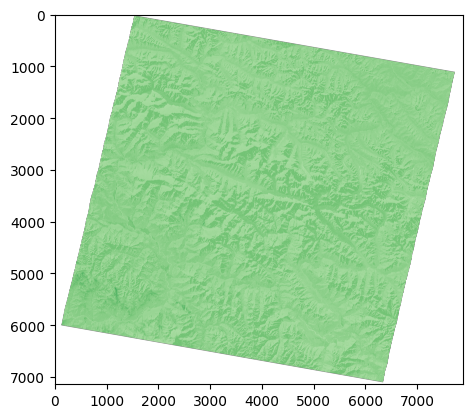

<Axes: >

In [56]:
rasterio.plot.show(ndvi, cmap='Greens')

In [54]:
ndvi = ((r[1] - r[0])/(r[1] + r[0]))
ndvi

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(7141, 7891))

In [55]:
np.nanmin(ndvi), np.nanmax(ndvi)

(np.float64(-0.9921875), np.float64(0.9921875))

In [57]:
meta.update(count=1, dtype=r.dtype, nodata=np.nan)
meta

{'driver': 'GTiff',
 'dtype': dtype('float64'),
 'nodata': nan,
 'width': 7891,
 'height': 7141,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 43N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32643"]]'),
 'transform': Affine(30.0, 0.0, 401085.0,
        0.0, -30.0, 4096515.0)}

In [58]:
with rasterio.open('data/LE07_L1TP_149035_20010101_20200917_02_T1/LE07_L1TP_149035_20010101_20200917_02_T1_ndvi.tif', 'w', **meta) as f:
    f.write(ndvi, 1)

add NDSI